<a href="https://colab.research.google.com/github/HadarRosenwald/severity-detection/blob/main/TabularModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/HadarRosenwald/severity-detection/blob/main/TabularModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchxrayvision
!pip -q install image_tabular

In [ ]:
# torch.__version__

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
import torch
import torchxrayvision as xrv
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import fastai
from fastai.tabular.data import TabularList
import image_tabular as imtab
from sklearn.model_selection import train_test_split
import math

from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [ ]:
# !rm -rf covid-chestxray-dataset

# **Creating label**

In [ ]:
def generate_label(x):
    # no data
    if np.all(pd.isna([x.survival, x.intubated, x.went_icu, x.needed_supplemental_O2])):
        return np.NaN

    # didn't survive
    if x.survival=='N':
        return '4'

    #either survived or survival is unknown
    if x.intubated == 'Y':
        return '3'
    if x.survival=='Y':
        if x.went_icu == 'Y' or x.needed_supplemental_O2 == 'Y':
            return '1'
    if x.went_icu == 'Y' or x.needed_supplemental_O2 == 'Y':
        return '2'
    return '0'

In [ ]:
metadata = d.csv
metadata['severity_class']=metadata.apply(generate_label, axis=1)

# **Tabular Data handling**

In [ ]:
filtered_metadata = metadata.loc[(metadata.view!="APS") & (metadata.offset>=0) & (metadata.offset<=8) & (metadata.intubation_present != 'Y') & (metadata.in_icu != 'Y')]
# filtered_metadata = filtered_metadata[['index','patientid','sex','age','RT_PCR_positive','temperature','pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'survival', 'intubated', 'went_icu', 'needed_supplemental_O2','filename']]
filtered_metadata = filtered_metadata[['index','patientid','sex','age','RT_PCR_positive','temperature','pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'severity_class' ,'filename']]

In [ ]:
data_path = Path("./covid-chestxray-dataset/")

In [ ]:
train_df, test_df = train_test_split(filtered_metadata, test_size=0.2)
# train_df = train_df.dropna(subset=['survival', 'intubated', 'went_icu', 'needed_supplemental_O2'], how='any')
# test_df = test_df.dropna(subset=['survival', 'intubated', 'went_icu', 'needed_supplemental_O2'], how='any')

train_df = train_df.dropna(subset=['severity_class'], how='any')
test_df = test_df.dropna(subset=['severity_class'], how='any')

train_df.head()

,index,patientid,sex,age,RT_PCR_positive,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,severity_class,filename
265,434,229,F,NaN,Unclear,NaN,55.0,NaN,NaN,NaN,0,2cd63b76.jpg
445,765,399,F,62.0,NaN,NaN,NaN,NaN,NaN,NaN,3,000001-4.jpg
323,547,291,F,61.0,Y,37.6,NaN,NaN,NaN,NaN,0,296_2020_4584_Fig2_HTML-a.png
268,438,233,M,NaN,Unclear,NaN,25.0,NaN,2.2,0.4,1,441c9cdd.jpg
397,673,358,F,25.0,Y,NaN,NaN,NaN,NaN,NaN,0,b0f1684d1ee90dc09deef015e29dae_jumbo.jpeg


In [ ]:
val_idx = get_valid_index(train_df)
# Features with categorical values
cat_names = ['sex', 'RT_PCR_positive', 'severity_class']
# Features with continious values
cont_names = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']
# Target
# dep_var = ['survival', 'intubated', 'went_icu', 'needed_supplemental_O2']
dep_var = ['severity_class']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs).split_by_idx(val_idx).label_from_df(cols=dep_var))

tab_data.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, processor=tab_data.train.x.processor))

LabelLists;

Train: LabelList (82 items)
x: TabularList
sex F; RT_PCR_positive Unclear; severity_class 0; age_na True; temperature_na True; pO2_saturation_na False; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.1223; temperature 0.0809; pO2_saturation -0.7301; leukocyte_count -0.0496; neutrophil_count -0.1245; lymphocyte_count -0.1266; ,sex F; RT_PCR_positive #na#; severity_class 3; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.6793; temperature 0.0809; pO2_saturation 0.0315; leukocyte_count -0.0496; neutrophil_count -0.1245; lymphocyte_count -0.1266; ,sex M; RT_PCR_positive Unclear; severity_class 1; age_na True; temperature_na True; pO2_saturation_na False; leukocyte_count_na True; neutrophil_count_na False; lymphocyte_count_na False; age 0.1223; temperature 0.0809; pO2_saturation -2.6342; leukocyte_count -0.0496; neutrophil_count -0.9672; lymphocyte_co

In [ ]:
# embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()
# output size, will be concatenated with the CNN, same output size
tab_out_sz = 18
# The tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[18], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(6, 4)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=34, out_features=18, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=18, out_features=18, bias=True)
  )
)

# **Image Data handling**

In [ ]:
def create_sub_image_folder(dataframe, imgs_type, sub_dir_by_lable : bool):
  filtered_imgpath = d.imgpath + '/' + imgs_type + '/'
  filtered_filenames = dataframe.filename + ';' + dataframe.severity_class
  if not os.path.exists(filtered_imgpath):
      os.mkdir(filtered_imgpath)
  if sub_dir_by_lable:
    for severity_class in list(dataframe.severity_class):
        if not os.path.exists(filtered_imgpath + f'/{severity_class}'):
            os.mkdir(filtered_imgpath + f'/{severity_class}')
  for file_name_label in filtered_filenames:
      file_name, label = file_name_label.split(';')
      src = d.imgpath + file_name
      dst = filtered_imgpath + label + '/' + file_name if sub_dir_by_lable else filtered_imgpath + file_name
      if not os.path.exists(dst):
          shutil.copyfile(src, dst)

In [ ]:
create_sub_image_folder(train_df, 'train', False)
create_sub_image_folder(test_df, 'test', False)
filtered_img_base_path = d.imgpath + '/'

In [ ]:
# train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                        transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.5), (0.5))])

# test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                      transforms.Resize(255),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor()])

# train_data = datasets.ImageFolder(filtered_img_base_path + '/train', transform=train_transforms)
# test_data = datasets.ImageFolder(filtered_img_base_path + '/test', transform=test_transforms)
# # train_data, val_data, test_data = split_data(data)

# trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [ ]:
tfms = get_transforms()
size=224

image_data = (ImageList.from_df(train_df, path=d.imgpath, cols="filename",
                               folder="train", convert_mode = 'L').split_by_idx(val_idx)
              .label_from_df(cols=dep_var)).transform(tfms, size=size, resize_method=ResizeMethod.SQUISH)
            
test_image_data = ImageList.from_df(test_df, path=d.imgpath, cols="filename",
                                    folder="test", convert_mode = 'L')
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (82 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: CategoryList
0,3,1,0,4
Path: covid-chestxray-dataset/images;

Valid: LabelList (20 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: CategoryList
0,0,0,1,0
Path: covid-chestxray-dataset/images;

Test: LabelList (36 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: EmptyLabelList
,,,,
Path: covid-chestxray-dataset/images

In [ ]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.classifier

Linear(in_features=1024, out_features=18, bias=True)

In [ ]:
# Don't backprop model parameters!
for param in model.parameters():
    param.requires_grad = False
    
# New classifier
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512,256),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(256,18))

#criterion = nn.NLLLoss()

# Training only the classifier parameters, model parameters remains unchanged
optimizer = optim.RMSprop(model.classifier.parameters(), lr=0.004)

In [ ]:
cnn_out_sz = 18
img_tabular_model = CNNTabularModel(model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2)

In [ ]:
img_tabular_model

CNNTabularModel(
  (cnn_model): XRV-DenseNet121-densenet121-res224-all
  (tabular_model): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(3, 3)
      (2): Embedding(6, 4)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(3, 3)
      (7): Embedding(3, 3)
      (8): Embedding(3, 3)
    )
    (emb_drop): Dropout(p=0.0, inplace=False)
    (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=34, out_features=18, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=18, out_features=18, bias=True)
    )
  )
  (layers): Sequential(
    (0): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2, inplace=False)
    (2)

In [ ]:
# class ImageTabDataset(Dataset):
#     def __init__(self, images, tabs):
#         """
#         Hybrid dataset that integrates image and tabular data.
#         :param images: a fastai LabelList that contains image data
#         :param tabs: a fastai LabelList that contains tabular data
#         """
#         self.images, self.tabs = images, tabs

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, i):
#         # return x as a tuple of image x and tabular x
#         # image y and tabular y should be the same
#         return (self.images[i][0], self.tabs[i][0]), self.images[i][1]


# def get_imagetabdatasets(image_data, tabular_data):
#     """
#     Helper function to construct train, valid, and optional test imagetabdatasets.
#     :param image_data: a fastai Labellists that contains image train, valid, and optional test Labellists
#     :param tabular_data: a fastai Labellists that contains tabular train, valid, and optional test Labellists
#     """
#     datasets = []
#     for images, tabs in zip(image_data.lists, tabular_data.lists):
#         print(f"###images:###\n{images}")
#         print(f"\n###tabs:###\n\n{tabs}")
#         datasets.append(ImageTabDataset(images, tabs))
#     return datasets

In [ ]:
integrate_train, integrate_val, integrate_test = get_imagetabdatasets(image_data, tab_data)


bs = 64
db = DataBunch.create(integrate_train, integrate_test, path=data_path, bs=bs)
learn = Learner(db, img_tabular_model, metrics=[accuracy, ROCAUC()], loss_func=torch.nn.NLLLoss)

###images:###
LabelList (82 items)
x: ImageList
Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224),Image (1, 224, 224)
y: CategoryList
0,3,1,0,4
Path: covid-chestxray-dataset/images

###tabs:###

LabelList (82 items)
x: TabularList
sex F; RT_PCR_positive Unclear; severity_class 0; age_na True; temperature_na True; pO2_saturation_na False; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.1223; temperature 0.0809; pO2_saturation -0.7301; leukocyte_count -0.0496; neutrophil_count -0.1245; lymphocyte_count -0.1266; ,sex F; RT_PCR_positive #na#; severity_class 3; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.6793; temperature 0.0809; pO2_saturation 0.0315; leukocyte_count -0.0496; neutrophil_count -0.1245; lymphocyte_count -0.1266; ,sex M; RT_PCR_positive Unclear; severity_class 1; age_na True; temperature_na True; pO2_saturation_na F

In [ ]:
# train
learn.fit_one_cycle(10, 1e-4)

# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time


RuntimeError: ignored

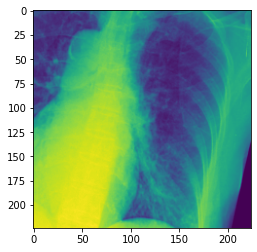

In [ ]:
for test_images, test_labels in trainloader:  
    plt.imshow(test_images[0][0])
    break